# PHASE 3: CLUSTERING ANALYSIS
## Find Optimal K using Elbow Method

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
PROJECT_ROOT= "/content/drive/MyDrive/image-clustering-retrieval"
features_normalized = np.load(f"{PROJECT_ROOT}/features/embeddings.npy")
labels = np.load(f"{PROJECT_ROOT}/features/labels.npy")

print(features_normalized.shape)

(4696, 2048)


------------------------------------------------------------
PHASE 3: CLUSTERING ANALYSIS
------------------------------------------------------------

🔍 Finding optimal K (testing K=10 to 100)...


Testing K values:  10%|█         | 1/10 [00:09<01:21,  9.04s/it]

  K= 10: Inertia=1415.76, Silhouette=0.1560


Testing K values:  20%|██        | 2/10 [00:22<01:35, 11.92s/it]

  K= 20: Inertia=1245.85, Silhouette=0.0997


Testing K values:  30%|███       | 3/10 [00:42<01:47, 15.34s/it]

  K= 30: Inertia=1131.32, Silhouette=0.1209


Testing K values:  40%|████      | 4/10 [01:07<01:55, 19.32s/it]

  K= 40: Inertia=1062.57, Silhouette=0.1262


Testing K values:  50%|█████     | 5/10 [01:38<01:57, 23.59s/it]

  K= 50: Inertia=1013.82, Silhouette=0.1185


Testing K values:  60%|██████    | 6/10 [02:18<01:56, 29.16s/it]

  K= 60: Inertia=978.18, Silhouette=0.1105


Testing K values:  70%|███████   | 7/10 [03:01<01:40, 33.57s/it]

  K= 70: Inertia=954.51, Silhouette=0.1159


Testing K values:  80%|████████  | 8/10 [03:47<01:14, 37.35s/it]

  K= 80: Inertia=936.59, Silhouette=0.1146


Testing K values:  90%|█████████ | 9/10 [04:41<00:42, 42.85s/it]

  K= 90: Inertia=922.88, Silhouette=0.0920


Testing K values: 100%|██████████| 10/10 [05:38<00:00, 33.84s/it]

  K=100: Inertia=913.61, Silhouette=0.0836


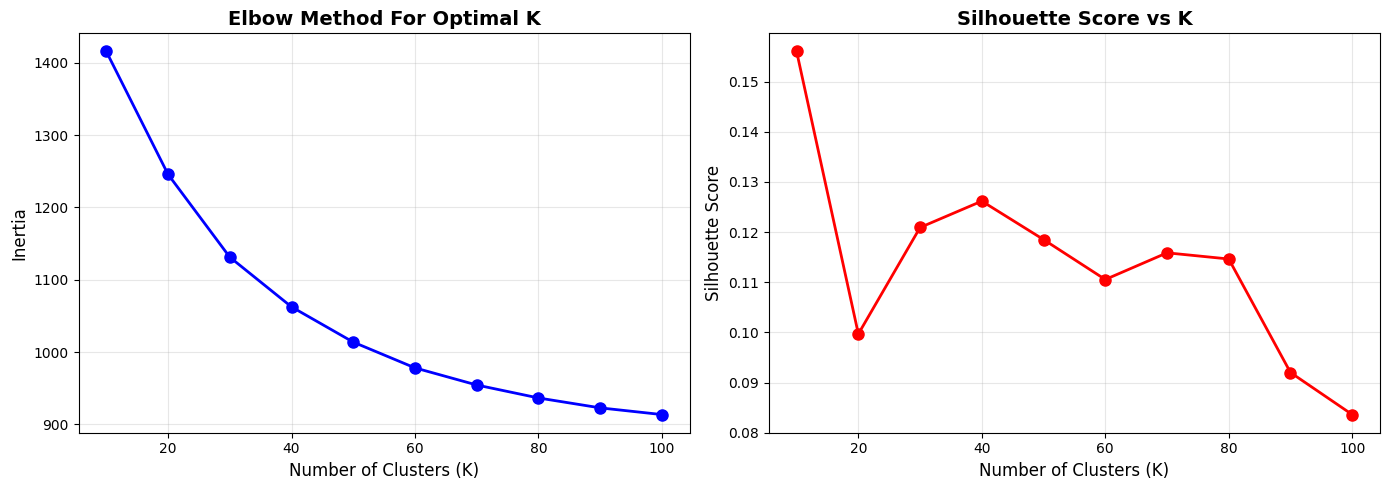


✅ Recommended K: 10 (highest silhouette score)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
print("-"*60)
print("PHASE 3: CLUSTERING ANALYSIS")
print("-"*60)

def find_optimal_k(features, k_range=(10, 100), step=10, sample_size=5000):
    """Find optimal K using elbow method"""
    # Sample for faster computation
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_sample = features[indices]
    else:
        features_sample = features

    k_values = list(range(k_range[0], k_range[1] + 1, step))
    inertias = []
    silhouette_scores_list = []

    print(f"\n🔍 Finding optimal K (testing K={k_range[0]} to {k_range[1]})...")

    for k in tqdm(k_values, desc="Testing K values"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_pred = kmeans.fit_predict(features_sample)
        inertias.append(kmeans.inertia_)

        # Calculate silhouette score on smaller sample
        sample_for_sil = min(3000, len(features_sample))
        sil_indices = np.random.choice(len(features_sample), sample_for_sil, replace=False)
        sil_score = silhouette_score(features_sample[sil_indices], labels_pred[sil_indices])
        silhouette_scores_list.append(sil_score)

        print(f"  K={k:3d}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax1.set_ylabel('Inertia', fontsize=12)
    ax1.set_title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    ax2.plot(k_values, silhouette_scores_list, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{PROJECT_ROOT}/results/clustering/elbow_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Find optimal K
    optimal_k = k_values[np.argmax(silhouette_scores_list)]
    print(f"\n✅ Recommended K: {optimal_k} (highest silhouette score)")

    return k_values, inertias, silhouette_scores_list, optimal_k

# Find optimal K using all features
k_vals, inertias, sil_scores, optimal_k = find_optimal_k(
    features_normalized,
    k_range=(10, 100),
    step=10,
    sample_size=5000)

# Perform K-Means Clustering

In [9]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle
from datetime import datetime
import json

def perform_kmeans(features, n_clusters, save_path):
    """Perform K-Means clustering"""
    print(f"\n🔧 Training K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=10,max_iter=300,verbose=1)
    cluster_labels = kmeans.fit_predict(features)

    # Evaluate
    print("\n📊 Evaluating clustering quality...")
    sample_size = min(10000, len(features))
    indices = np.random.choice(len(features), sample_size, replace=False)

    sil_score = silhouette_score(features[indices], cluster_labels[indices])
    db_score = davies_bouldin_score(features, cluster_labels)

    print(f"\n{'-'*60}")
    print("CLUSTERING METRICS")
    print(f"{'-'*60}")
    print(f"Silhouette Score:     {sil_score:.4f}  (higher is better)")
    print(f"Davies-Bouldin Index: {db_score:.4f}  (lower is better)")
    print(f"{'-'*60}")

    # Cluster statistics
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print("\n📈 Cluster Distribution:")
    for cluster_id, count in zip(unique[:10], counts[:10]):
        print(f"  Cluster {cluster_id:3d}: {count:5d} images ({count/len(cluster_labels)*100:.1f}%)")
    if len(unique) > 10:
        print(f"  ... and {len(unique)-10} more clusters")

    # Save model
    with open(f'{save_path}/kmeans_k{n_clusters}.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

    # Save cluster labels
    np.save(f'{save_path}/cluster_labels.npy', cluster_labels)

    # Save metrics
    metrics = {
        'n_clusters': n_clusters,
        'silhouette_score': float(sil_score),
        'davies_bouldin_score': float(db_score),
        'cluster_sizes': {int(k): int(v) for k, v in zip(unique, counts)},
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    with open(f'{save_path}/clustering_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    print(f"\n✅ K-Means model saved to {save_path}")

    return kmeans, cluster_labels, metrics

# Run clustering on all features
n_clusters = optimal_k
kmeans_model, cluster_labels, clustering_metrics = perform_kmeans(
    features_normalized,
    n_clusters=n_clusters,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)


🔧 Training K-Means with K=10...
Initialization complete
Iteration 0, inertia 2601.984375.
Iteration 1, inertia 1508.302978515625.
Iteration 2, inertia 1458.3720703125.
Iteration 3, inertia 1446.654052734375.
Iteration 4, inertia 1442.485595703125.
Iteration 5, inertia 1440.44189453125.
Iteration 6, inertia 1438.144775390625.
Iteration 7, inertia 1434.223876953125.
Iteration 8, inertia 1431.161865234375.
Iteration 9, inertia 1430.2640380859375.
Iteration 10, inertia 1429.9620361328125.
Iteration 11, inertia 1429.7301025390625.
Iteration 12, inertia 1429.576904296875.
Iteration 13, inertia 1429.2808837890625.
Iteration 14, inertia 1428.7164306640625.
Iteration 15, inertia 1428.16845703125.
Iteration 16, inertia 1427.9051513671875.
Iteration 17, inertia 1427.8409423828125.
Iteration 18, inertia 1427.822021484375.
Iteration 19, inertia 1427.8212890625.
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 2514.159423828125.
Iteration 1, inertia 1471.1

# HIERARCHICAL CLUSTERING (WITH K SELECTION)

🔧 Building linkage matrix (method=average)


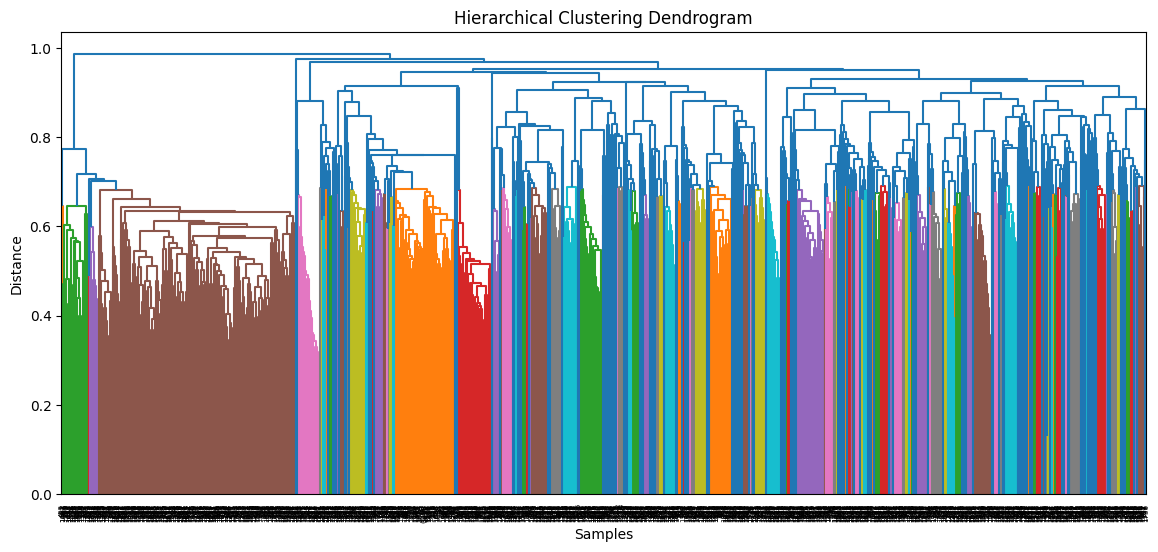

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# --------------------------
# STEP 1: Sample Features (Optional)
# --------------------------
def sample_features(features, sample_size=2000, random_state=42):
    if len(features) > sample_size:
        np.random.seed(random_state)
        indices = np.random.choice(len(features), sample_size, replace=False)
        return features[indices], indices
    return features, np.arange(len(features))

# --------------------------
# STEP 2: Build Linkage Matrix
# --------------------------
def build_linkage_matrix(features, method='average'):
    print(f"🔧 Building linkage matrix (method={method})")
    Z = linkage(features, method=method)
    return Z

# --------------------------
# STEP 3: Plot Dendrogram
# --------------------------
def plot_dendrogram(Z, truncate_level=30, max_d=None):
    plt.figure(figsize=(14, 6))
    dendrogram(Z, truncate_mode='level', p=truncate_level)
    if max_d:
        plt.axhline(y=max_d, c='r', linestyle='--')
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

# --------------------------
# STEP 4: Run Dendrogram Analysis
# --------------------------
# Sample features for efficiency
features_sampled, sample_indices = sample_features(features_normalized, sample_size=2000)

# Build linkage
Z = build_linkage_matrix(features_sampled, method='average')

# Plot dendrogram
plot_dendrogram(Z, truncate_level=30)

# Perform Hierarchical Clustering

In [12]:
import os
import json
import pickle
import numpy as np

from datetime import datetime

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --------------------------
# STEP 1: Train Hierarchical Clustering with Exact K
# --------------------------
def train_hierarchical_exact_k(features, k=50, linkage_type='average'):
    """
    Train AgglomerativeClustering to produce exactly K clusters
    """
    model = AgglomerativeClustering(
        n_clusters=k,       # Force exact K clusters
        linkage=linkage_type
    )
    labels = model.fit_predict(features)

    sil = silhouette_score(features, labels)
    db = davies_bouldin_score(features, labels)

    print("\nFINAL HIERARCHICAL RESULTS")
    print("-" * 50)
    print(f"Linkage:    {linkage_type}")
    print(f"K:          {k}")
    print(f"Silhouette: {sil:.4f}")
    print(f"DB Index:   {db:.4f}")
    print("-" * 50)

    return model, labels, sil, db

# --------------------------
# STEP 2: Full HIR Pipeline
# --------------------------
def perform_hir_pipeline(features, k=50, linkage_type='average', sample_size=5000, save_path=None):
    # 1️⃣ Sample features if needed
    if len(features) > sample_size:
        indices = np.random.choice(len(features), sample_size, replace=False)
        features_used = features[indices]
        print(f"Using {len(features_used)}/{len(features)} samples")
    else:
        features_used = features

    # 2️⃣ Train hierarchical clustering
    model, cluster_labels, sil, db = train_hierarchical_exact_k(features_used, k=k, linkage_type=linkage_type)

    # 3️⃣ Save model, labels, and metrics
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        with open(f'{save_path}/hir_model_k{k}.pkl', 'wb') as f:
            pickle.dump(model, f)
        np.save(f'{save_path}/hir_labels_k{k}.npy', cluster_labels)
        metrics = {
            'k': k,
            'linkage': linkage_type,
            'silhouette_score': float(sil),
            'davies_bouldin_score': float(db),
            'cluster_sizes': {int(c): int(np.sum(cluster_labels==c)) for c in np.unique(cluster_labels)},
            'sample_size': len(features_used),
            'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        with open(f'{save_path}/hir_metrics_k{k}.json', 'w') as f:
            json.dump(metrics, f, indent=2)
        print(f"\n✅ HIR model, labels, and metrics saved to {save_path}")

    return model, cluster_labels, sil, db

# --------------------------
# STEP 3: Run HIR
# --------------------------
hir_model, hir_labels, sil_score, db_score = perform_hir_pipeline(
    features_normalized,
    k=50,
    linkage_type='average',
    sample_size=5000,
    save_path=f'{PROJECT_ROOT}/models/clustering'
)

# Check clusters
print("Unique cluster IDs:", np.unique(hir_labels))
print("Number of clusters:", len(np.unique(hir_labels)))


FINAL HIERARCHICAL RESULTS
--------------------------------------------------
Linkage:    average
K:          50
Silhouette: 0.1819
DB Index:   2.1500
--------------------------------------------------

✅ HIR model, labels, and metrics saved to /content/drive/MyDrive/image-clustering-retrieval/models/clustering
Unique cluster IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Number of clusters: 50


# Visualize Clusters with t-SNE


🎨 Creating t-SNE visualization...
  Computing t-SNE (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


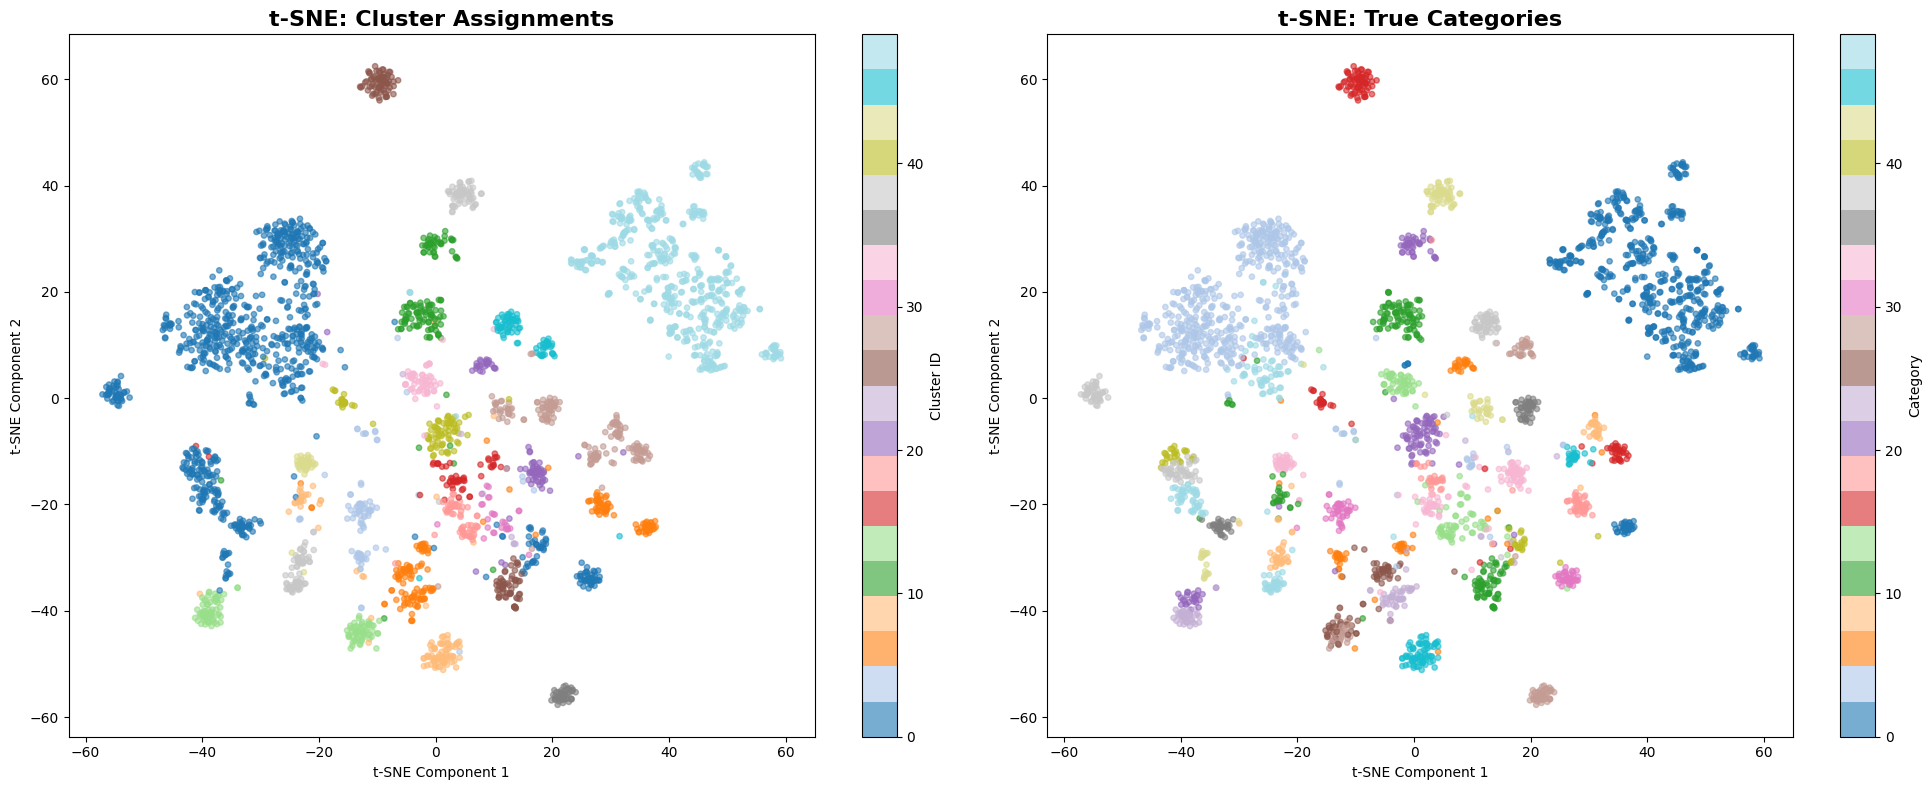

✅ t-SNE visualization complete!


In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsne(features, labels, cluster_labels, categories=None, sample_size=3000, save_path=None):
    """
    Create t-SNE visualization for hierarchical clusters and true categories side by side.

    Args:
        features (np.array): CNN embeddings (n_samples, n_features)
        labels (np.array): True labels/categories
        cluster_labels (np.array): Cluster labels from Hierarchical/KMeans
        categories (list or dict): Optional mapping of label indices to category names
        sample_size (int): Max samples to speed up t-SNE
        save_path (str): Path to save the figure
    """
    print("\n🎨 Creating t-SNE visualization...")

    # ---- Sampling ----
    n_samples = min(sample_size, len(features))
    indices = np.random.choice(len(features), n_samples, replace=False)
    features_sample = features[indices]
    labels_sample = labels[indices]
    cluster_sample = cluster_labels[indices]

    # ---- t-SNE projection ----
    print("  Computing t-SNE (this may take a few minutes)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca', learning_rate='auto')
    features_2d = tsne.fit_transform(features_sample)

    # ---- Plotting ----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Cluster assignments
    scatter1 = ax1.scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=cluster_sample, cmap='tab20', alpha=0.6, s=15
    )
    ax1.set_title('t-SNE: Cluster Assignments', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

    # True categories
    scatter2 = ax2.scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=labels_sample, cmap='tab20', alpha=0.6, s=15
    )
    ax2.set_title('t-SNE: True Categories', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter2, ax=ax2, label='Category')

    plt.tight_layout()

    # ---- Save figure ----
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    print("✅ t-SNE visualization complete!")

# ===============================
# USAGE EXAMPLE
# ===============================
visualize_tsne(
    features=features_normalized,
    labels=labels,                # True labels of dataset
    cluster_labels=hir_labels,   # Hierarchical cluster labels
    categories=None,              # Optional: list of category names
    sample_size=3000,
    save_path=f'{PROJECT_ROOT}/results/clustering/tsne_plot.png'
)

# Analyze Cluster Composition


📊 Analyzing HIR cluster composition...

Cluster 0 (948 images, entropy=0.80):
  • airplanes: 797 (84.1%)
  • helicopter: 83 (8.8%)
  • ferry: 67 (7.1%)
  • bonsai: 1 (0.1%)


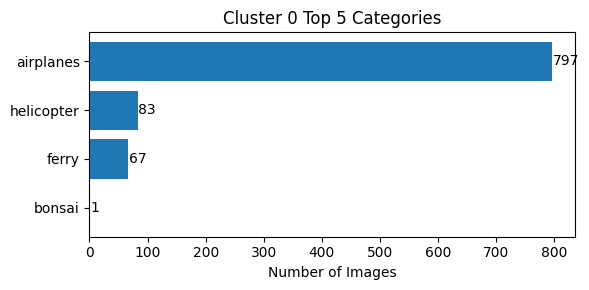


Cluster 1 (287 images, entropy=2.67):
  • ibis: 78 (27.2%)
  • flamingo: 63 (22.0%)
  • emu: 53 (18.5%)
  • flamingo_head: 38 (13.2%)
  • gerenuk: 33 (11.5%)


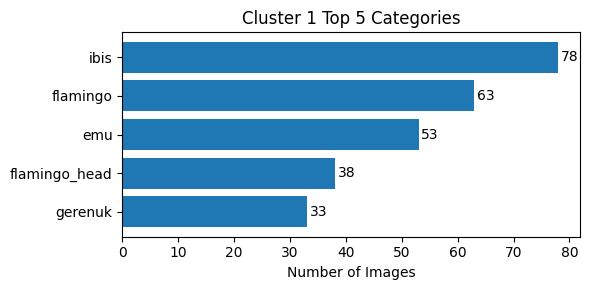


Cluster 2 (119 images, entropy=2.54):
  • dollar_bill: 52 (43.7%)
  • garfield: 33 (27.7%)
  • bass: 6 (5.0%)
  • brain: 6 (5.0%)
  • cougar_face: 5 (4.2%)


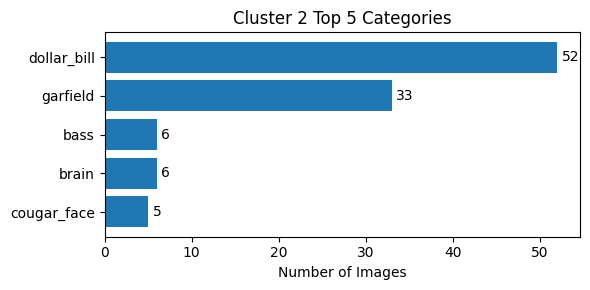


Cluster 3 (26 images, entropy=1.52):
  • anchor: 19 (73.1%)
  • electric_guitar: 2 (7.7%)
  • helicopter: 1 (3.8%)
  • crayfish: 1 (3.8%)
  • ceiling_fan: 1 (3.8%)


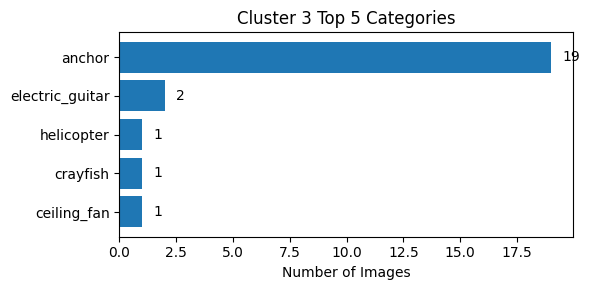


Cluster 4 (114 images, entropy=1.73):
  • dolphin: 61 (53.5%)
  • bass: 39 (34.2%)
  • brontosaurus: 3 (2.6%)
  • crocodile: 3 (2.6%)
  • beaver: 2 (1.8%)


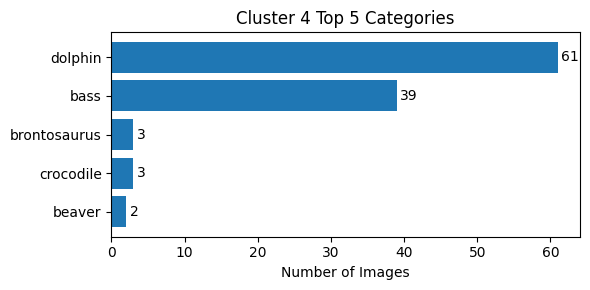


Cluster 5 (170 images, entropy=1.76):
  • crab: 68 (40.0%)
  • crayfish: 63 (37.1%)
  • ant: 33 (19.4%)
  • bass: 2 (1.2%)
  • dragonfly: 2 (1.2%)


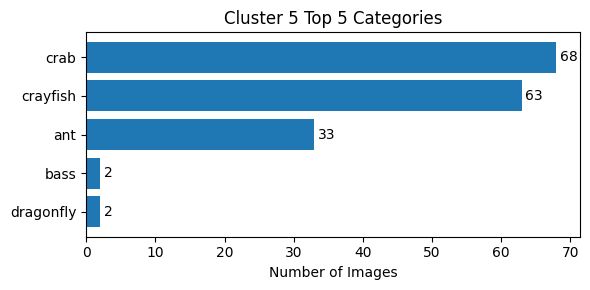


Cluster 6 (7 images, entropy=2.24):
  • brontosaurus: 2 (28.6%)
  • butterfly: 2 (28.6%)
  • electric_guitar: 1 (14.3%)
  • chair: 1 (14.3%)
  • crab: 1 (14.3%)


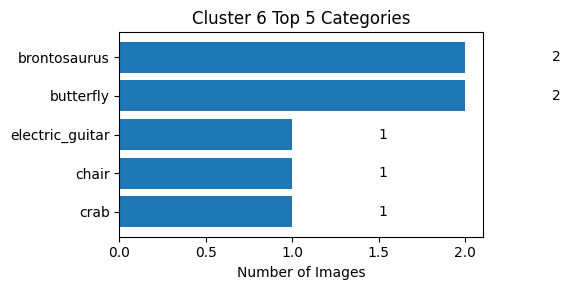


Cluster 7 (117 images, entropy=1.19):
  • cellphone: 59 (50.4%)
  • accordion: 55 (47.0%)
  • headphone: 1 (0.9%)
  • cup: 1 (0.9%)
  • bass: 1 (0.9%)


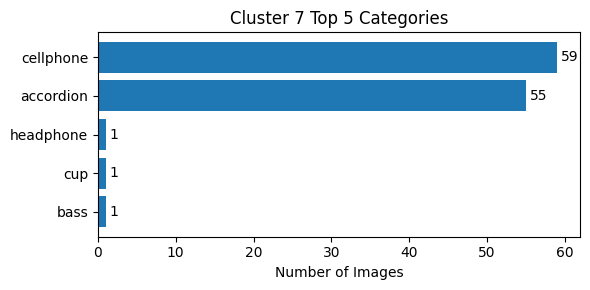


Cluster 8 (44 images, entropy=2.50):
  • brontosaurus: 24 (54.5%)
  • elephant: 5 (11.4%)
  • cougar_body: 3 (6.8%)
  • ibis: 2 (4.5%)
  • dolphin: 2 (4.5%)


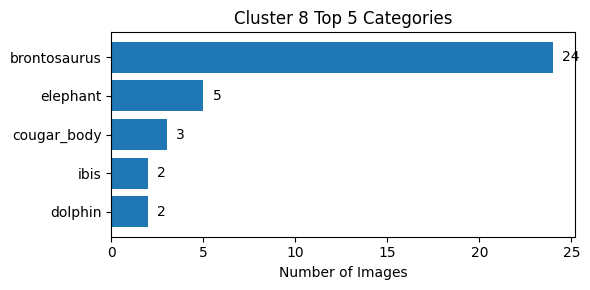


Cluster 9 (109 images, entropy=0.60):
  • hawksbill: 100 (91.7%)
  • crocodile_head: 2 (1.8%)
  • crocodile: 2 (1.8%)
  • butterfly: 2 (1.8%)
  • bass: 2 (1.8%)


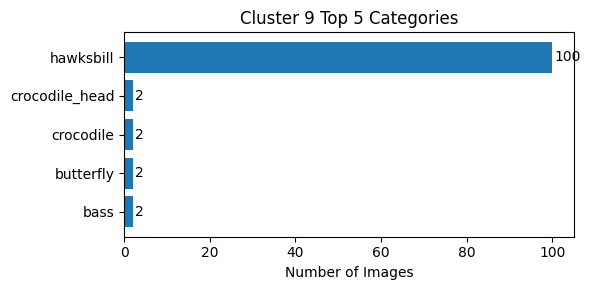


Cluster 10 (64 images, entropy=0.55):
  • chair: 59 (92.2%)
  • chandelier: 2 (3.1%)
  • gramophone: 1 (1.6%)
  • euphonium: 1 (1.6%)
  • ceiling_fan: 1 (1.6%)


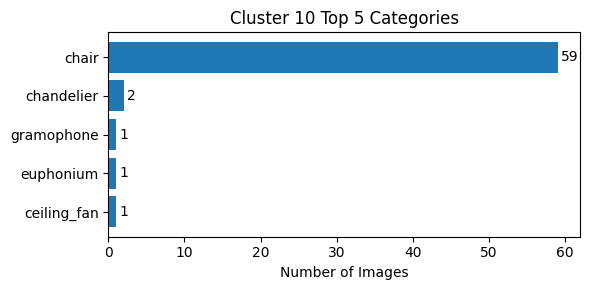


Cluster 11 (118 images, entropy=0.07):
  • bonsai: 117 (99.2%)
  • gramophone: 1 (0.8%)


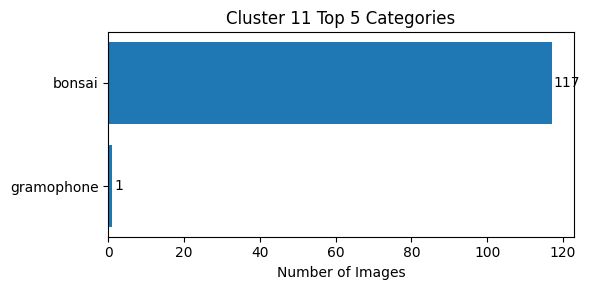


Cluster 12 (4 images, entropy=2.00):
  • flamingo: 1 (25.0%)
  • elephant: 1 (25.0%)
  • dolphin: 1 (25.0%)
  • bass: 1 (25.0%)


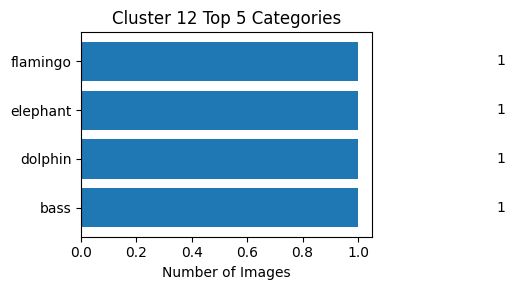


Cluster 13 (106 images, entropy=0.97):
  • cougar_face: 64 (60.4%)
  • cougar_body: 42 (39.6%)


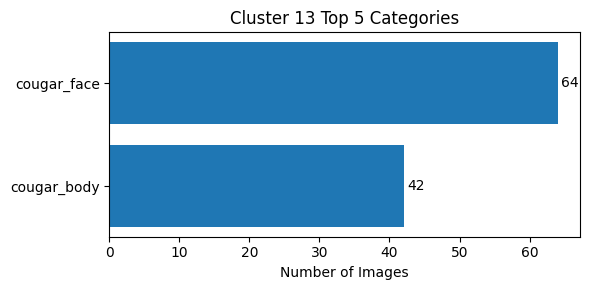


Cluster 14 (89 images, entropy=1.08):
  • crocodile_head: 46 (51.7%)
  • crocodile: 42 (47.2%)
  • bass: 1 (1.1%)


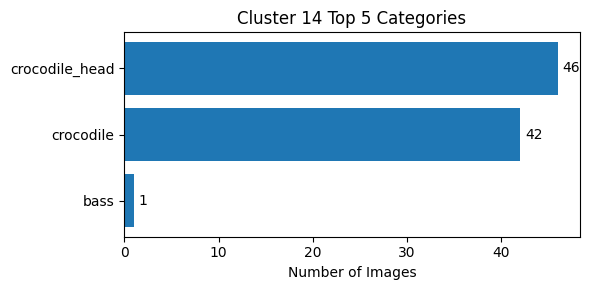


Cluster 15 (2 images, entropy=1.00):
  • crocodile: 1 (50.0%)
  • bonsai: 1 (50.0%)


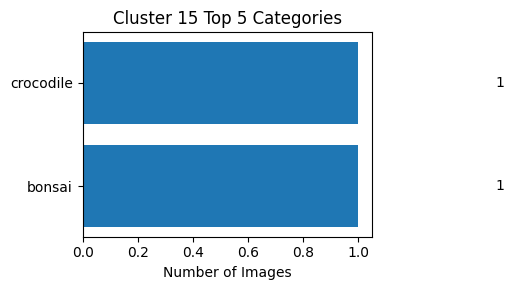


Cluster 16 (6 images, entropy=0.65):
  • flamingo_head: 5 (83.3%)
  • flamingo: 1 (16.7%)


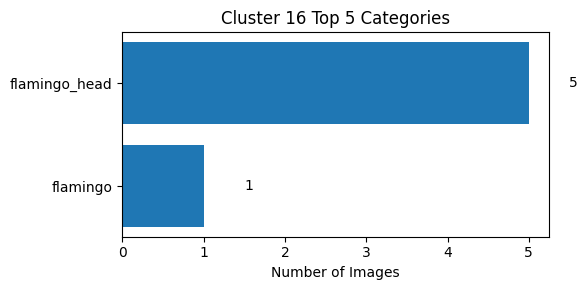


Cluster 17 (76 images, entropy=1.80):
  • ceiling_fan: 44 (57.9%)
  • anchor: 17 (22.4%)
  • dragonfly: 7 (9.2%)
  • chandelier: 3 (3.9%)
  • electric_guitar: 2 (2.6%)


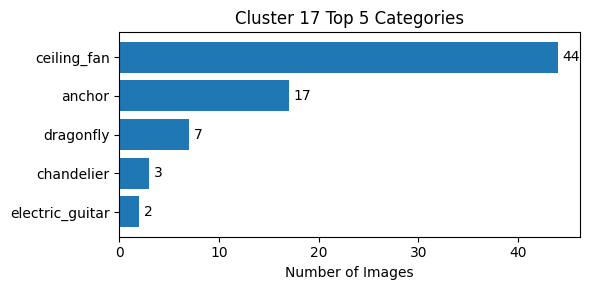


Cluster 18 (2 images, entropy=-0.00):
  • crayfish: 2 (100.0%)


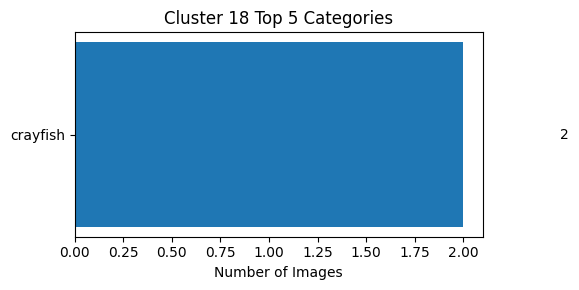


Cluster 19 (98 images, entropy=1.14):
  • dragonfly: 48 (49.0%)
  • butterfly: 48 (49.0%)
  • ceiling_fan: 1 (1.0%)
  • ant: 1 (1.0%)


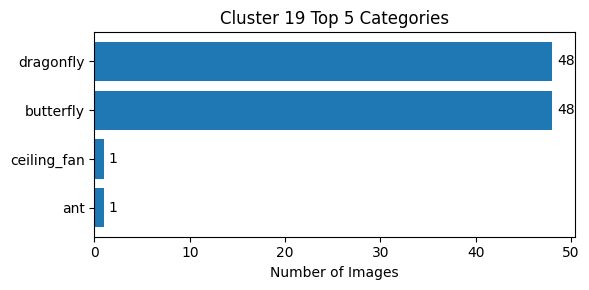


Cluster 20 (42 images, entropy=-0.00):
  • barrel: 42 (100.0%)


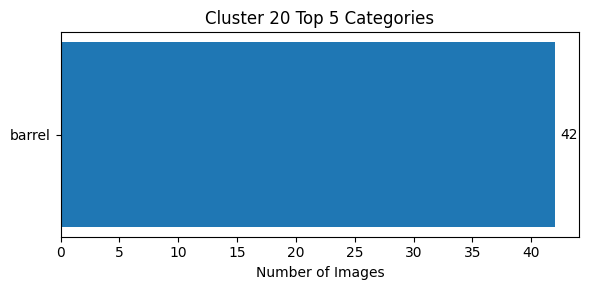


Cluster 21 (8 images, entropy=2.50):
  • crayfish: 2 (25.0%)
  • barrel: 2 (25.0%)
  • crab: 1 (12.5%)
  • cannon: 1 (12.5%)
  • brain: 1 (12.5%)


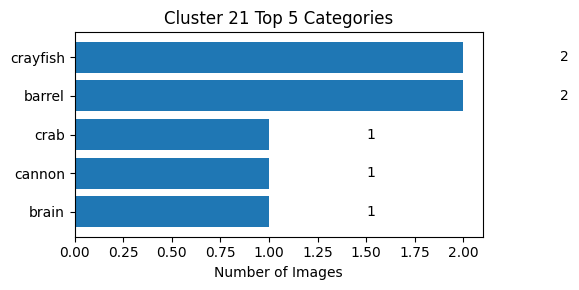


Cluster 22 (71 images, entropy=0.29):
  • electric_guitar: 68 (95.8%)
  • anchor: 2 (2.8%)
  • airplanes: 1 (1.4%)


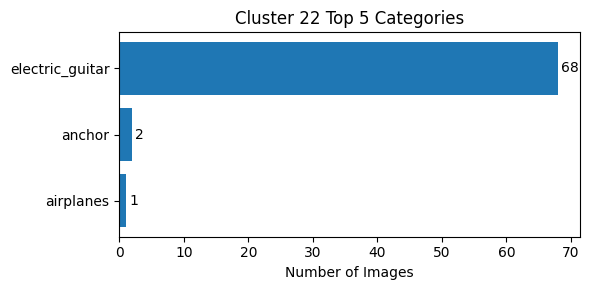


Cluster 23 (7 images, entropy=2.52):
  • chandelier: 2 (28.6%)
  • dragonfly: 1 (14.3%)
  • crab: 1 (14.3%)
  • chair: 1 (14.3%)
  • bass: 1 (14.3%)


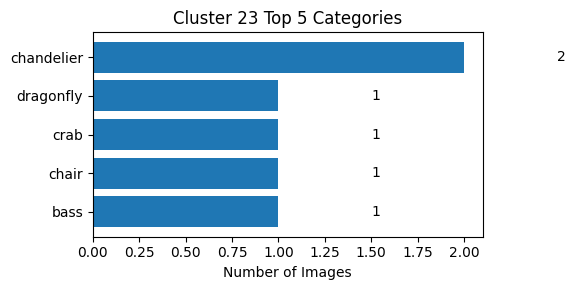


Cluster 24 (2 images, entropy=1.00):
  • flamingo_head: 1 (50.0%)
  • buddha: 1 (50.0%)


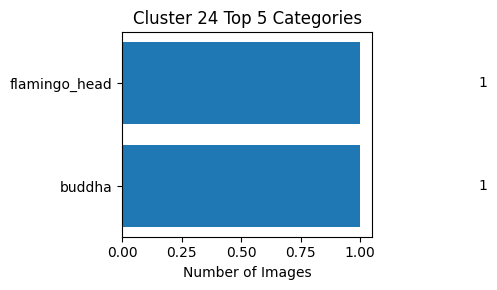


Cluster 25 (123 images, entropy=-0.00):
  • car_side: 123 (100.0%)


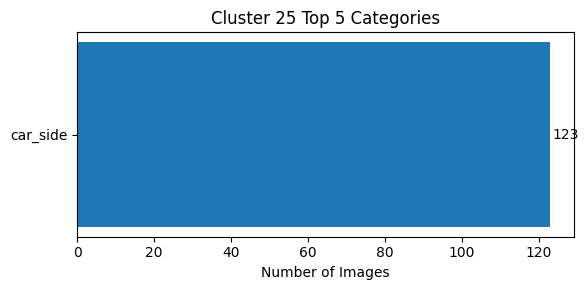


Cluster 26 (92 images, entropy=0.09):
  • brain: 91 (98.9%)
  • butterfly: 1 (1.1%)


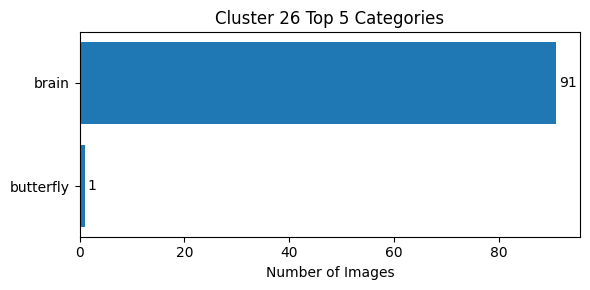


Cluster 27 (109 images, entropy=0.98):
  • euphonium: 63 (57.8%)
  • gramophone: 46 (42.2%)


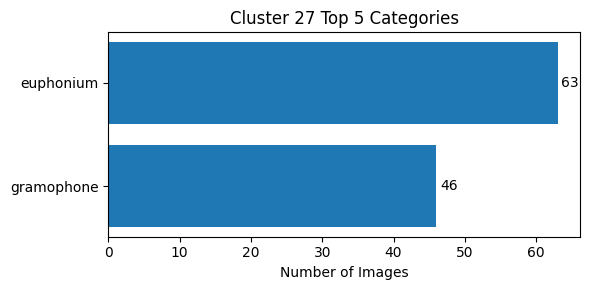


Cluster 28 (3 images, entropy=1.58):
  • crab: 1 (33.3%)
  • cannon: 1 (33.3%)
  • butterfly: 1 (33.3%)


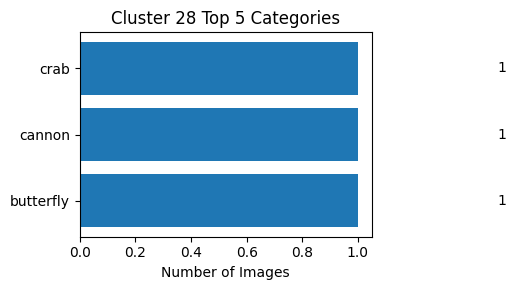


Cluster 29 (131 images, entropy=1.94):
  • camera: 50 (38.2%)
  • headphone: 40 (30.5%)
  • binocular: 33 (25.2%)
  • cup: 2 (1.5%)
  • anchor: 2 (1.5%)


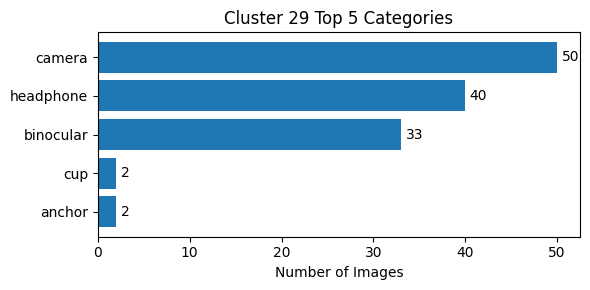


Cluster 30 (42 images, entropy=1.25):
  • butterfly: 29 (69.0%)
  • dragonfly: 9 (21.4%)
  • ant: 3 (7.1%)
  • dalmatian: 1 (2.4%)


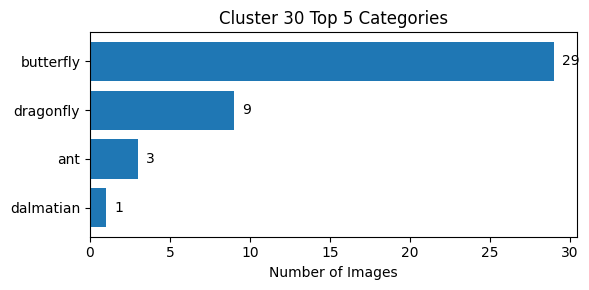


Cluster 31 (1 images, entropy=-0.00):
  • ant: 1 (100.0%)


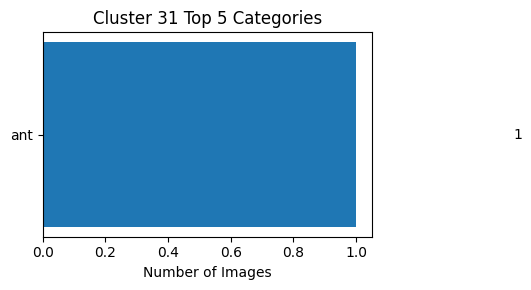


Cluster 32 (89 images, entropy=0.60):
  • buddha: 81 (91.0%)
  • Faces: 3 (3.4%)
  • Faces_easy: 3 (3.4%)
  • ewer: 1 (1.1%)
  • chandelier: 1 (1.1%)


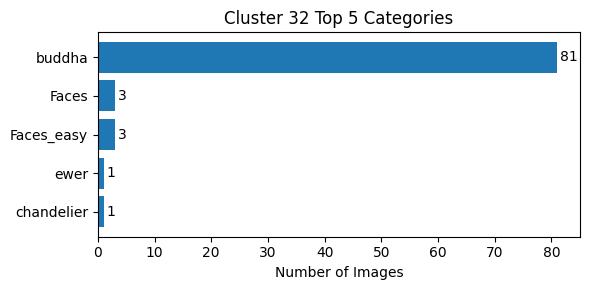


Cluster 33 (1 images, entropy=-0.00):
  • bonsai: 1 (100.0%)


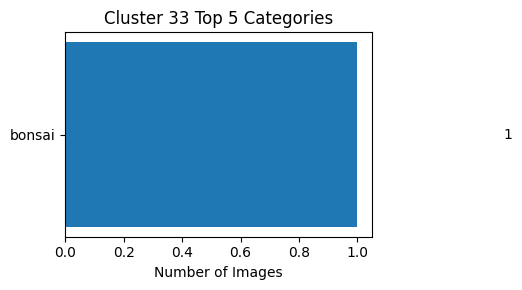


Cluster 34 (3 images, entropy=1.58):
  • helicopter: 1 (33.3%)
  • grand_piano: 1 (33.3%)
  • chandelier: 1 (33.3%)


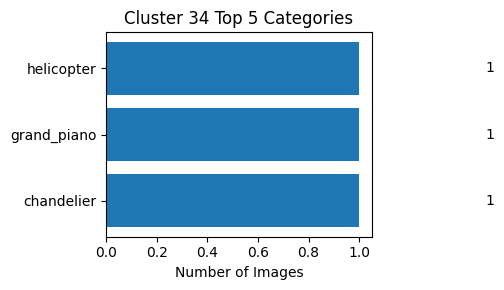


Cluster 35 (1 images, entropy=-0.00):
  • airplanes: 1 (100.0%)


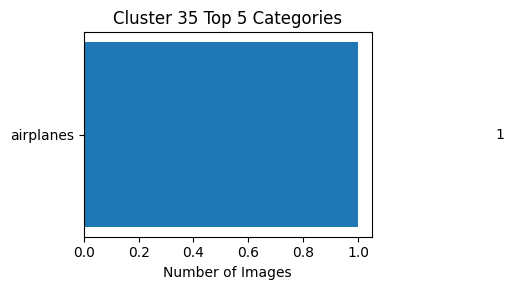


Cluster 36 (66 images, entropy=-0.00):
  • dalmatian: 66 (100.0%)


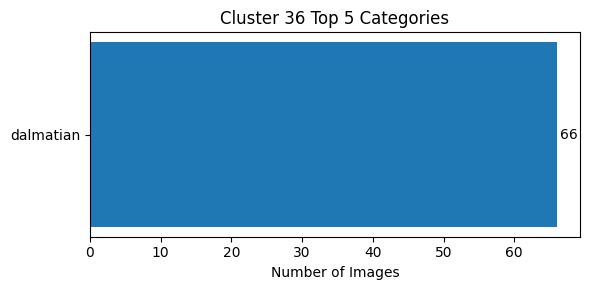


Cluster 37 (92 images, entropy=0.98):
  • hedgehog: 53 (57.6%)
  • beaver: 39 (42.4%)


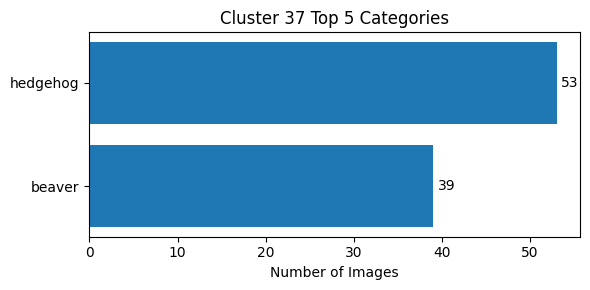


Cluster 38 (98 images, entropy=-0.00):
  • grand_piano: 98 (100.0%)


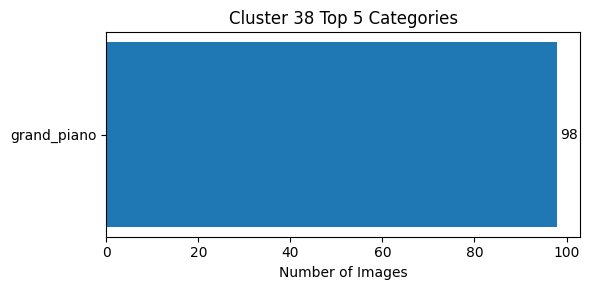


Cluster 39 (1 images, entropy=-0.00):
  • butterfly: 1 (100.0%)


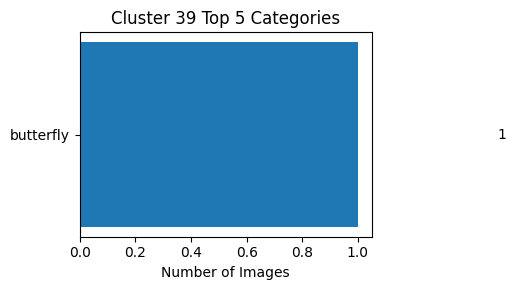


Cluster 40 (40 images, entropy=0.50):
  • cannon: 37 (92.5%)
  • gramophone: 1 (2.5%)
  • brontosaurus: 1 (2.5%)
  • barrel: 1 (2.5%)


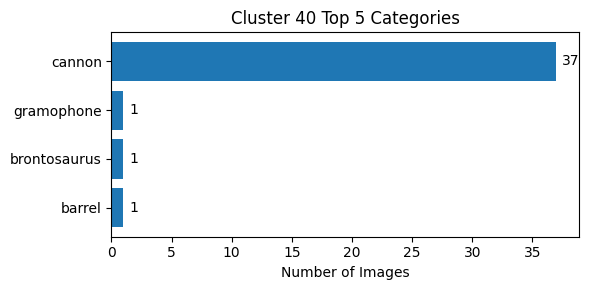


Cluster 41 (100 images, entropy=0.24):
  • chandelier: 97 (97.0%)
  • ewer: 1 (1.0%)
  • electric_guitar: 1 (1.0%)
  • ant: 1 (1.0%)


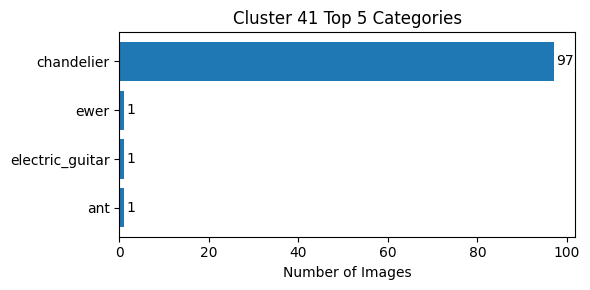


Cluster 42 (3 images, entropy=1.58):
  • hedgehog: 1 (33.3%)
  • crocodile_head: 1 (33.3%)
  • beaver: 1 (33.3%)


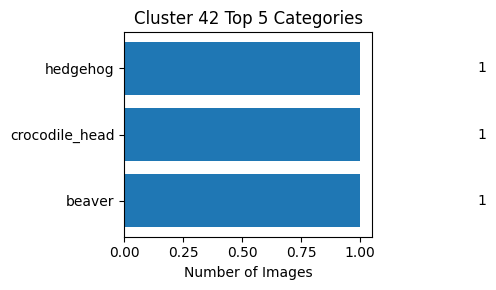


Cluster 43 (2 images, entropy=1.00):
  • dolphin: 1 (50.0%)
  • beaver: 1 (50.0%)


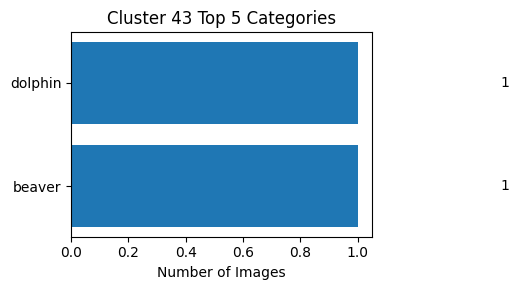


Cluster 44 (59 images, entropy=0.34):
  • elephant: 56 (94.9%)
  • brontosaurus: 2 (3.4%)
  • cougar_body: 1 (1.7%)


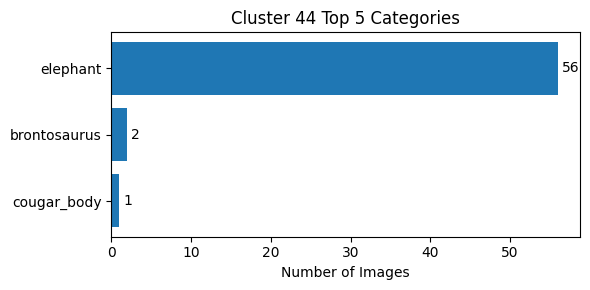


Cluster 45 (134 images, entropy=0.96):
  • ewer: 82 (61.2%)
  • cup: 52 (38.8%)


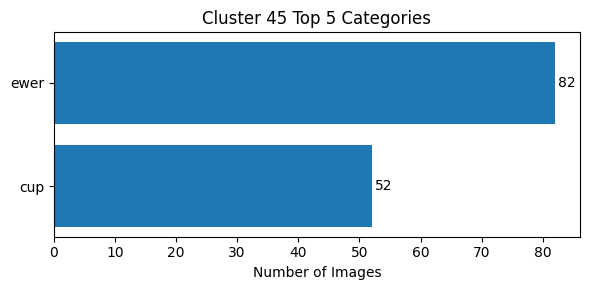


Cluster 46 (2 images, entropy=1.00):
  • garfield: 1 (50.0%)
  • crayfish: 1 (50.0%)


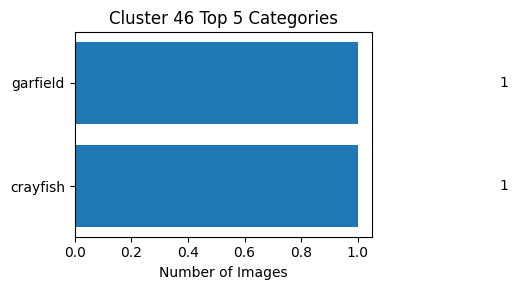


Cluster 47 (862 images, entropy=1.00):
  • Faces_easy: 431 (50.0%)
  • Faces: 431 (50.0%)


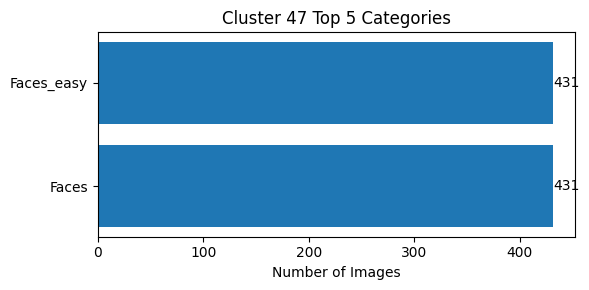


Cluster 48 (2 images, entropy=1.00):
  • chandelier: 1 (50.0%)
  • butterfly: 1 (50.0%)


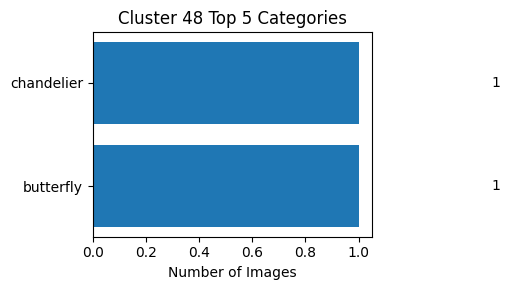


Cluster 49 (4 images, entropy=-0.00):
  • bonsai: 4 (100.0%)


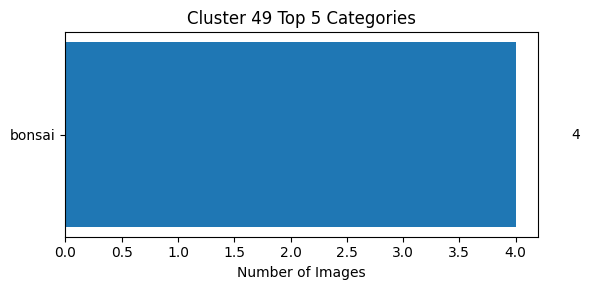

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

def analyze_clusters_hir_plot(cluster_labels, true_labels, categories, top_n=50, top_k_per_cluster=5):
    """
    Analyze cluster composition for HIR and plot horizontal bar plots for top categories.
    """
    print("\n📊 Analyzing HIR cluster composition...")
    n_clusters = len(np.unique(cluster_labels))
    cluster_info = []

    for cluster_id in range(min(top_n, n_clusters)):
        mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[mask]
        cluster_size = len(cluster_true_labels)

        if cluster_size == 0:
            continue

        unique, counts = np.unique(cluster_true_labels, return_counts=True)
        sorted_idx = np.argsort(counts)[::-1][:top_k_per_cluster]

        top_categories = [
            (categories[unique[i]], counts[i], counts[i] / cluster_size * 100)
            for i in sorted_idx
        ]

        probs = counts / counts.sum()
        entropy = -np.sum(probs * np.log2(probs + 1e-9))

        cluster_info.append({
            "cluster_id": cluster_id,
            "size": cluster_size,
            "top_categories": top_categories,
            "entropy": entropy
        })

        print(f"\nCluster {cluster_id} ({cluster_size} images, entropy={entropy:.2f}):")
        for cat, count, pct in top_categories:
            print(f"  • {cat}: {count} ({pct:.1f}%)")

        plt.figure(figsize=(6, 3))
        cats = [cat for cat, _, _ in top_categories][::-1]
        counts_plot = [count for _, count, _ in top_categories][::-1]

        plt.barh(cats, counts_plot)
        plt.xlabel("Number of Images")
        plt.title(f"Cluster {cluster_id} Top {top_k_per_cluster} Categories")

        for i, v in enumerate(counts_plot):
            plt.text(v + 0.5, i, str(v), va="center")

        plt.tight_layout()
        plt.show()

    return cluster_info


# --------------------------
# LOAD REQUIRED DATA (NO DATASET OBJECTS)
# --------------------------

features_normalized = np.load(f"{PROJECT_ROOT}/features/embeddings.npy")
labels = np.load(f"{PROJECT_ROOT}/features/labels.npy")

dataset_path = os.path.join(PROJECT_ROOT, "data/processed/object")
categories = sorted([
    d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d))
])

# --------------------------
# RUN ANALYSIS
# --------------------------

cluster_analysis_hir = analyze_clusters_hir_plot(
    cluster_labels=hir_labels,
    true_labels=labels,
    categories=categories,
    top_n=50,
    top_k_per_cluster=5
)